#Линейные модели

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

## Логистическая регрессия

_Логистическая регрессия_ - частный случай линейного классификатора, обладающий одной полезной особенностью - помимо отнесения объекта к определенному классу она умеет прогнозировать вероятность $P$ того, что объект относится к этому классу.


Пусть в каждой точке пространства объектов $\mathbb{X}$ задана вероятность того, что объект $x$ будет принадлежать к классу "+1" $P(y=1|x)$ (условная вероятность $y = 1$ при условии $x$). Она будет принимать значения от 0 до 1, и нам нужно каким-то образом ее предсказывать, но пока мы умеем только строить прогноз методами линейной регрессии с помощью некоего алгоритма $b(x)=\left \langle w,x_{i} \right \rangle$. У него есть проблема, связанная с тем, что скалярное произведение $\left \langle w,x_{i} \right \rangle$ не всегда возвращает значения в отрезке [0, 1]. Чтобы достичь такого условия, можно использовать некую функцию $\sigma:\mathbb{R} \rightarrow [0,1]$, которая будет переводить полученное в скалярном произведении значение в вероятность, пределы которой будут лежать в промежутке от 0 до 1. 

### Рабочая часть модели

В модели логистической регрессии в качестве такой функции берется сигмоида, которая имеет вид:

$$z(x_{i})=\left \langle w,x_{i} \right \rangle$$

$$\sigma(z) = \frac{1}{1 + exp(-z)}.$$


### Потери

В случае, когда $y$ принимает значения 0 и 1, log loss запишется как

$$-\text{ln}L(X) = -\sum^{l}_{i=1} (y_{i} \text{ln}\frac{1}{1 + exp(-\left \langle w,x_{i} \right \rangle)} + (1 - y_{i})\text{ln} \frac{exp(-\left \langle w,x_{i} \right \rangle)}{1 + exp(-\left \langle w,x_{i} \right \rangle)}).$$



$$-\text{ln}L(X) = -\sum^{l}_{i=1} ( y_{i} \text{ln}\ sigma(z_{i}) + (1 - y_{i})\text{ln} ( 1  -  sigma(z_{i}))).$$

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
import warnings

warnings.filterwarnings( "ignore")

Реализация логистической регрессии :

In [92]:
#
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#
def log_loss(w, X, y):
    m = X.shape[1]
    

    # используем функцию сигмоиды, написанную ранее
    A = sigmoid(np.dot(w.T, X))
    
    loss = -1.0 / m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
    loss = np.squeeze(loss)
    grad = 1.0 / m * np.dot(X, (A - y).T)
    
    return loss, grad

#
def optimize(w, X, y, n_iterations, eta):
#     потери будем записывать в список для отображения в виде графика
    losses = []
    X = X.T
    X = np.vstack((np.ones((1,X.shape[1])),X))
    
    for i in range(n_iterations):        
        loss, grad = log_loss(w, X, y)
        w = w - eta * grad
            
#добавить выход когда w next и w тек меньше чем eps (eta*grad) > eps
        losses.append(loss)
        if (eta*grad).all() > eta: 
            break
    #print(eta*grad)
    #if (eta*grad).all() > eta: 
        
    return w, losses
#
def predict(w, X):
    X = X.T
    m = X.shape[1]
    X = np.vstack((np.ones((1,X.shape[1])),X))
    y_predicted = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X))
    
#     За порог отнесения к тому или иному классу примем вероятность 0.5
    for i in range(A.shape[1]):
        if (A[:,i] > 0.5): 
            y_predicted[:, i] = 1
        elif (A[:,i] <= 0.5):
            y_predicted[:, i] = 0
    
    return y_predicted

In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

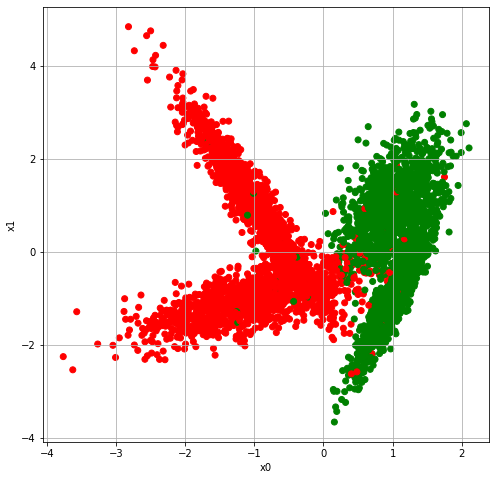

In [6]:
from sklearn import datasets
from matplotlib.colors import ListedColormap

# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=5000, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=110)
# 

#classes = datasets.make_blobs(n_samples=1000,centers = 2, cluster_std = 1., random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue','green'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)
plt.grid()
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()


In [93]:
# разбиение данных на тренировочные и отложенную выборку (тестовые), 
#где X, y - описание примеров и их целевое свойство (классы), а test_size=0.2 - пропорция разбиения (доля тестов)
X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(classes[0], classes[1], test_size=0.2, random_state=1)

# иницилизируем начальный вектор весов
w0 = np.zeros((X_train_tr.shape[1]+1, 1))+0.1
n_iterations = 500
eta = 0.05

w, losses = optimize(w0, X_train_tr, y_train_tr, n_iterations, eta)

y_predicted_test = predict(w, X_test_tr)
y_predicted_train = predict(w, X_train_tr)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train_tr)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test_tr)*100.0)

print(f"Итоговый вектор весов w: {w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[0.09860281]
 [0.1230989 ]
 [0.09795607]]
Точность на обучающей выборке: 69.200
Точность на тестовой выборке: 70.800


In [72]:
# разбиение данных на тренировочные и отложенную выборку (тестовые), 
#где X, y - описание примеров и их целевое свойство (классы), а test_size=0.2 - пропорция разбиения (доля тестов)
X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(classes[0], classes[1], test_size=0.2, random_state=1)

# иницилизируем начальный вектор весов
w0 = np.zeros((X_train_tr.shape[1]+1, 1))+0.1
n_iterations = 1000
eta = 0.05

w, losses = optimize(w0, X_train_tr, y_train_tr, n_iterations, eta)

y_predicted_test = predict(w, X_test_tr)
y_predicted_train = predict(w, X_train_tr)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train_tr)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test_tr)*100.0)

print(f"Итоговый вектор весов w: {w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[-0.45660008]
 [ 3.54007378]
 [ 0.13499012]]
Точность на обучающей выборке: 97.175
Точность на тестовой выборке: 98.100


### **Задание 1.**

1.1 Измените модель логистической регрессии из кода выше на модель с условием выхода по числу итераций (это есть ) и разнице параметров w для двух последовательных шагов.

1.2 Измените модель для сохранения на каждом шаге изменения параметров w ошибки модели в тестовом наборе данных (на отложенной выборке)

1.3 Добавьте собственную реализацию вычисления Accuracy

1.4 Оцените (постройте кривые изменения Accuracy и потерь для тестовой(отложенной выборки) ) поведение модели при использовании одного критерия останова и 2-х (исходная схема модели и модель по п.1.1) 

1.5  зафиксируйте результаты в таблице и сделайте выводы

In [8]:
#сделать пункт 1
#создание данных
classes = datasets.make_classification(n_samples=5000, n_features=2, n_informative=2,n_redundant=0, n_classes=2, random_state=110)

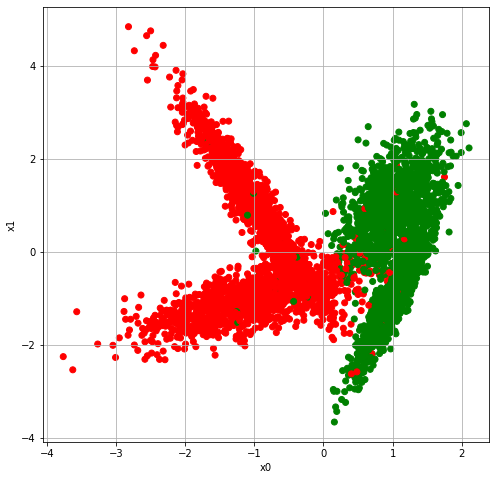

In [9]:
# и изобразим их на графике
colors = ListedColormap(['red', 'blue','green'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)
plt.grid()
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [94]:
# разбиение данных на тренировочные и отложенную выборку (тестовые), 
#где X, y - описание примеров и их целевое свойство (классы), а test_size=0.2 - пропорция разбиения (доля тестов)
X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(classes[0], classes[1], test_size=0.2, random_state=1)

# иницилизируем начальный вектор весов
w0 = np.zeros((X_train_tr.shape[1]+1, 1))+0.1
n_iterations = 500
eta = 0.0005

w, losses = optimize(w0, X_train_tr, y_train_tr, n_iterations, eta)

y_predicted_test = predict(w, X_test_tr)
y_predicted_train = predict(w, X_train_tr)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train_tr)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test_tr)*100.0)

print(f"Итоговый вектор весов w: {w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[0.09998603]
 [0.10023099]
 [0.09997956]]
Точность на обучающей выборке: 67.400
Точность на тестовой выборке: 67.700


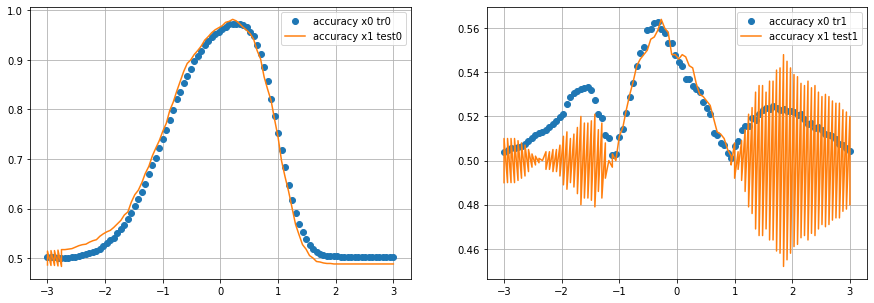

In [95]:
acc_1 = []
acc_t_1 = []
for tr in np.linspace(-3,3,100):
    
    y_p = (X_train_tr[:,1] > tr).astype(int)
    y_pt = (X_test_tr[:,1] > tr).astype(int)
    acc2 = accuracy_score(y_train_tr,y_p) 
    acc1 = accuracy_score(y_train_tr,1-y_p)
    f = 0
    if acc2>acc1:
        acc_1 += [[tr, acc2]]
        acc_t_1 += [[tr,accuracy_score(y_test_tr,y_pt)]] 
    else:
        f=1
        acc_1 += [[tr, acc1]]
        acc_t_1 += [[tr,accuracy_score(y_test_tr,1-y_pt)]] 
        
    acc_t_1 += [[tr,accuracy_score(y_test_tr,y_pt)]] 
    # print(acc_1[-1][0],acc_1[-1][1],acc_t_1[-1][0],acc_t_1[-1][1])
acc_1 = np.array(acc_1)
acc_t_1 = np.array(acc_t_1)

acc_0 = []
acc_t_0 = []
for tr in np.linspace(-3,3,100):
    y_p = (X_train_tr[:,0] > tr).astype(int)
    y_pt = (X_test_tr[:,0] > tr).astype(int)
    acc2 = accuracy_score(y_train_tr,y_p) 
    acc1 = accuracy_score(y_train_tr,1-y_p)
    f = 0
    if acc2>acc1:
        acc_0 += [[tr, acc2]]
        acc_t_0 += [[tr,accuracy_score(y_test_tr,y_pt)]] 
    else:
        f=1
        acc_0 += [[tr, acc1]]
        acc_t_0 += [[tr,accuracy_score(y_test_tr,1-y_pt)]] 
        
    acc_t_0 += [[tr,accuracy_score(y_test_tr,y_pt)]] 
    # print(acc_0[-1][0],acc_0[-1][1],acc_t_0[-1][0],acc_t_0[-1][1])
acc_0 = np.array(acc_0)
acc_t_0 = np.array(acc_t_0)

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(acc_0[:,0],acc_0[:,1],'o',label = 'accuracy x0 tr0')
plt.plot(acc_t_0[:,0],acc_t_0[:,1],'-',label = 'accuracy x1 test0')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(acc_1[:,0],acc_1[:,1],'o',label = 'accuracy x0 tr1')
plt.plot(acc_t_1[:,0],acc_t_1[:,1],'-',label = 'accuracy x1 test1')
plt.legend()
plt.grid()
plt.show()


In [12]:
# создадим модель
from sklearn.linear_model import LogisticRegression
logistic_regressor = LogisticRegression(penalty='l2', tol = 0.001, max_iter=10, multi_class='auto', solver='saga' )

# обучим ее
logistic_regressor.fit(X_train_tr, y_train_tr)

# выведем полученный вес при признаке и свободный коэффициент
print(logistic_regressor.coef_[0], logistic_regressor.intercept_)

[5.30071456 0.08376057] [-1.2474325]


In [13]:
y_pred = logistic_regressor.predict(X_test_tr)  # жесткий ответ (метка класса)
y_pred_proba = logistic_regressor.predict_proba(X_test_tr) # вероятностная оценка класса

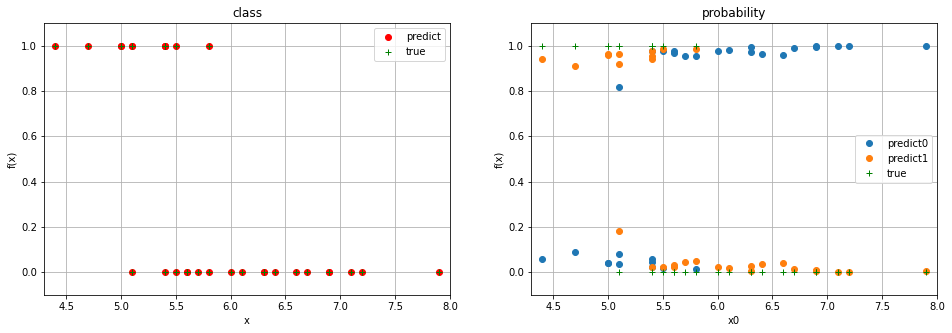

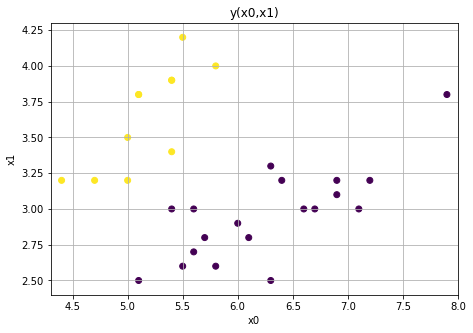

accuracy:  1.0


In [38]:
n = 0 # номер признака для визуализации.
plt.figure(figsize = (16,5))

ymin = y_test_tr.min()-0.1
ymax = y_test_tr.max()+0.1
xmin = X_test_tr[:,n].min()-0.1
xmax = X_test_tr[:,n].max()+0.1

plt.subplot(1,2,1)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.plot(X_test_tr[:,n], y_pred,'or', label = 'predict')
plt.plot(X_test_tr[:,n], y_test_tr, '+g', label = 'true')
plt.grid()
plt.legend()
plt.title('class')

plt.subplot(1,2,2)

plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.title('probability')

for m in range(y_pred_proba.shape[1]):
  if m>1:
    mk = m
  else : mk = 1
  plt.plot(X_test_tr[:,n], y_pred_proba[:,m]*mk,'o', label = 'predict'+ str(m) )

plt.plot(X_test_tr[:,n], y_test_tr, '+g', label = 'true')
plt.grid()
plt.legend()
plt.xlabel('x0')
plt.ylabel('f(x)')



plt.show()


plt.figure(figsize = (7.3,5))
n2 = 1
xmin0 = X_test_tr[:,n2].min()-0.1
xmax0 = X_test_tr[:,n2].max()+0.1

plt.xlabel('x0')
plt.ylabel('x1')
plt.ylim(xmin0,xmax0)
plt.xlim(xmin,xmax)
plt.scatter(X_test_tr[:,n],X_test_tr[:,n2], c = y_test_tr)
plt.title('y(x0,x1)')

plt.grid()

plt.show()


print('accuracy: ',accuracy_score(y_test_tr,y_pred))

На графиках видно, что классификация проходит не очень надежно по признаку х1 и очень хорошо по признаку х0 (практически разделяющий по значению х0 == 0, все для х0<0 соответствует метке 0, все для х0>0 м= метка 1)

In [39]:
print('accuracy: ',accuracy_score(y_test_tr,y_pred))

accuracy:  1.0


In [40]:
print(classification_report(y_test_tr, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



### **Задание 2.**

1.1  Проведите эксперимент(для кода из результата задания 1) с изменением шага обучения eta в диапазоне (0.1, 2) с дискретностью 0.1

1.2  зафиксируйте результаты в таблице и сделайте выводы


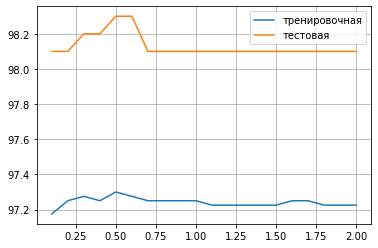

In [41]:
# разбиение данных на тренировочные и отложенную выборку (тестовые), 
#где X, y - описание примеров и их целевое свойство (классы), а test_size=0.2 - пропорция разбиения (доля тестов)
X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(classes[0], classes[1], test_size=0.2, random_state=1)

# иницилизируем начальный вектор весов
w0 = np.zeros((X_train_tr.shape[1]+1, 1))+0.1
n_iterations = 500

train = list([])
test = list([])
b = list([])

def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

for i in frange(0.1,2.1,0.1):
  eta = i
  w, losses = optimize(w0, X_train_tr, y_train_tr, n_iterations, eta)

  y_predicted_test = predict(w, X_test_tr)
  y_predicted_train = predict(w, X_train_tr)

  # В качестве меры точности возьмем долю правильных ответов
  train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train_tr)*100.0)
  train.append(train_accuracy)
  test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test_tr)*100.0)
  test.append(test_accuracy)
  b.append(eta)


plt.plot(b,train)
plt.plot(b,test)
plt.grid()
plt.legend({'тренировочная','тестовая'})


In [42]:
df = pd.DataFrame([train, test], index = ('Точность на обучающей выборке','Точность на тестовой выборке'), columns = b)
df

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0
Точность на обучающей выборке,97.175,97.25,97.275,97.25,97.3,97.275,97.25,97.25,97.25,97.25,97.225,97.225,97.225,97.225,97.225,97.25,97.25,97.225,97.225,97.225
Точность на тестовой выборке,98.100,98.10,98.200,98.20,98.3,98.300,98.10,98.10,98.10,98.10,98.100,98.100,98.100,98.100,98.100,98.10,98.10,98.100,98.100,98.100


Вывод: точность на обучающей выборке начиная с шага обучения eta=0.7 перестала повышаться, на тестовой же с 0.5

## Sklearn LogisticRegression

Классификатор логистической регрессии (также известный как логит, MaxEnt) https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

  - Класс реализует логистическую регрессию с использованием библиотеки «liblinear», решателей «newton-cg», «sag», «saga» и «lbfgs». 

  - Регуляризация применяется по умолчанию (не для всех решателей одинаковая).

  - В случае с несколькими классами алгоритм обучения использует схему «один против остальных» (OvR)


  - penalty {'l1', 'l2', 'elasticnet', 'none'}, по умолчанию = 'l2':

      - 'none': пенальти не добавляется;

      - 'l2': штраф L2 (по умолчанию);

      - 'l1': штраф L1;

      -  'elasticnet': штраф L1 и L2.

  - tol: критерий останова по изменению параметров модели default=1e-4

  - class_weight - dict или ‘balanced’, default=None. Веса, классов для случая разбалансированных данных (большему классу ставим меньший вес) . Если не указано, предполагается, что все классы имеют вес один.{class_label: weight}
. Режим ‘balanced’использует значения y для автоматической корректировки весов обратно пропорционально частотам классов во входных данных как .n_samples / (n_classes * np.bincount(y))

  - solver : решатель {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, по умолчанию = 'lbfgs'. Алгоритм для использования в задаче оптимизации. Значение по умолчанию — 'lbfgs'. Для небольших наборов данных хорошим выбором является «liblinear», «sag» и «saga» работают быстрее для больших.Для многоклассовых задач только «newton-cg», «sag», «saga» и «lbfgs». Выбор алгоритма и штрафа связаны. Поддерживаемые решателем штрафы:

      - ‘newton-cg’ - [‘l2’, ‘none’]
      - ‘lbfgs’ - [‘l2’, ‘none’]
      - ‘liblinear’ - [‘l1’, ‘l2’]
      - ‘sag’ - [‘l2’, ‘none’]
      - ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]


  - max_iter : критерий останова по числу итераций, по умолчанию = 100
Максимальное количество итераций, необходимых для сходимости решателей.

  - multi_class {‘auto’, ‘ovr’, ‘multinomial’}, по умолчанию = ‘auto’. Если выбрана опция 'ovr', то для каждой метки решается бинарная задача. Для ‘multinomial’ минимизация потерь — это ‘multinomial’ потери, подходящие для всего распределения вероятностей, даже если данные являются двоичными . 
  - n_jobs : Количество ядер ЦП, используемых при распараллеливании по классам, если multi_class='ovr'». None означает 1,  -1 означает использование всех процессоров. 

  - l1_ratio параметр регуляризации Elastic-Net для комбинирования L1 и L2.




In [43]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

## SKlearn метрики

Модуль sklearn.metrics предоставляет набор простых функций, измеряющих ошибку предсказания с учетом истинности и предсказания:

  - функции, заканчивающиеся на, _score возвращают значение для максимизации, чем выше, тем лучше.
  - функции, заканчивающиеся на _error или _loss возвращающие значение, которое нужно минимизировать, чем ниже, тем лучше. 
  

Некоторые из них ограничены случаем двоичной классификации:

  - precision_recall_curve(y_true, probas_pred, *)	Вычислите пары точности-полноты для разных пороговых значений вероятности.
  - roc_curve(y_true, y_score, *[, pos_label, …])	Вычислить рабочую характеристику приемника (ROC).

Другие работают в случае мультикласса:

  - balanced_accuracy_score(y_true, y_pred, *[, …])	Вычислите сбалансированную точность.
  - confusion_matrix(y_true, y_pred, *[, …])	Вычислите матрицу неточностей, чтобы оценить точность классификации.
  - roc_auc_score(y_true, y_score, *[, average, …])	Вычислить площадь под кривой рабочих характеристик приемника (ROC AUC) по оценкам прогнозов.

Работают универсально:

  - accuracy_score(y_true, y_pred, *[, …])	Классификационная оценка accuracy.
  - classification_report(y_true, y_pred, *[, …])	Создайте текстовый отчет, показывающий основные показатели классификации.
  - f1_score(y_true, y_pred, *[, labels, …])	Вычислите оценку F1, также известную как сбалансированная оценка F или F-мера.
  - fbeta_score(y_true, y_pred, *, beta[, …])	Вычислите оценку F-beta.

  - log_loss(y_true, y_pred, *[, eps, …]) кросс-энтропия или логистические потери.

  - multilabel_confusion_matrix(y_true, y_pred, *)	Вычислите матрицу неточностей для каждого класса или образца.
  - precision_recall_fscore_support(y_true, …)	Точность , полнота, F-мера и поддержка для каждого класса.
  - precision_score(y_true, y_pred, *[, labels, …])	Вычислите точность.
  - recall_score(y_true, y_pred, *[, labels, …])	Вычислите отзыв.
  - roc_auc_score(y_true, y_score, *[, average, …])	Вычислить площадь под кривой рабочих характеристик приемника (ROC AUC) по оценкам прогнозов.

### **Пример:**

  - для синтетического набора строим логистическую регрессию и оцениваем ее оп метрике accuracy

In [44]:

from sklearn.linear_model import LogisticRegression
# создадим модель
logistic_regressor = LogisticRegression(penalty='l2', tol = 0.001, max_iter=10, multi_class='auto', solver='saga' )

# обучим ее
logistic_regressor.fit(X_train_tr, y_train_tr)

# выведем полученный вес при признаке и свободный коэффициент
print(logistic_regressor.coef_[0], logistic_regressor.intercept_)

[5.30316511 0.08109348] [-1.24860527]


  - на тестовом наборе получим предсказание в форме класса (.predict()) и в вероятностной оценки каждого класса (.predict_proba())

In [45]:
y_pred = logistic_regressor.predict(X_test_tr)  # жесткий ответ (метка класса)
y_pred_proba = logistic_regressor.predict_proba(X_test_tr) # вероятностная оценка класса

  - визуализируем результаты и определим значение метрики

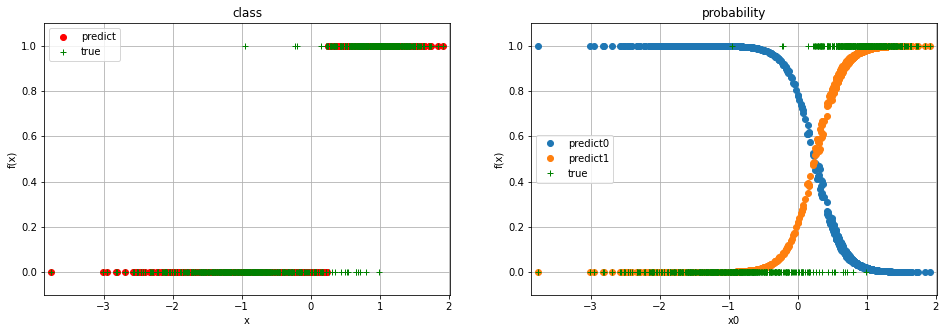

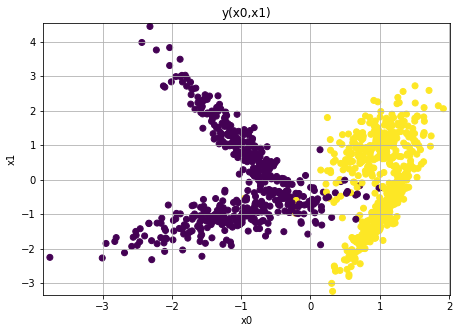

accuracy:  0.981


In [46]:


n = 0 # номер признака для визуализации. проверить результат для n = 1
plt.figure(figsize = (16,5))

ymin = y_test_tr.min()-0.1
ymax = y_test_tr.max()+0.1
xmin = X_test_tr[:,n].min()-0.1
xmax = X_test_tr[:,n].max()+0.1

plt.subplot(1,2,1)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.plot(X_test_tr[:,n], y_pred,'or', label = 'predict')
plt.plot(X_test_tr[:,n], y_test_tr, '+g', label = 'true')
plt.grid()
plt.legend()
plt.title('class')

plt.subplot(1,2,2)

plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.title('probability')

for m in range(y_pred_proba.shape[1]):
  if m>1:
    mk = m
  else : mk = 1
  plt.plot(X_test_tr[:,n], y_pred_proba[:,m]*mk,'o', label = 'predict'+ str(m) )

plt.plot(X_test_tr[:,n], y_test_tr, '+g', label = 'true')
plt.grid()
plt.legend()
plt.xlabel('x0')
plt.ylabel('f(x)')



plt.show()


plt.figure(figsize = (7.3,5))
n2 = 1
xmin0 = X_test_tr[:,n2].min()-0.1
xmax0 = X_test_tr[:,n2].max()+0.1

plt.xlabel('x0')
plt.ylabel('x1')
plt.ylim(xmin0,xmax0)
plt.xlim(xmin,xmax)
plt.scatter(X_test_tr[:,n],X_test_tr[:,n2], c = y_test_tr)
plt.title('y(x0,x1)')

plt.grid()

plt.show()


print('accuracy: ',accuracy_score(y_test_tr,y_pred))

На графиках видно, что классификация проходит не очень надежно по признаку х1 и очень хорошо по признаку х0 (практически разделяющий по значению х0 == 0, все для х0<0 соответствует метке 0, все для х0>0 м= метка 1)





  - сформируем отчет о классификации 

In [47]:
print(classification_report(y_test_tr, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       488
           1       0.97      0.99      0.98       512

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



  - проведем эксперимент для нескольких перезапусков алгоритма (К) и различных сочетаний значений гиперпараметров (tol, max_iter). Сделаем сеточный поиск в пространстве вариантов для множества К = 10 реализаций 

In [48]:
import seaborn as sns

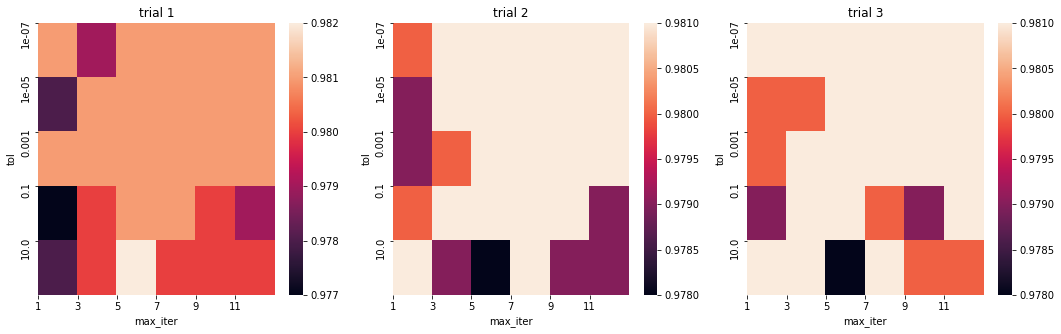

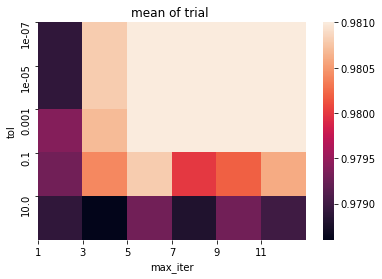

In [49]:
# Эксперимент
rez = []
K = 10
for tol in np.logspace(-7,1,5):
  for max_iter in range(1,12,2):
    acc = []
    for k in range(K):
      logistic_regressor = LogisticRegression( tol = tol, max_iter=max_iter, solver = 'saga')
      # обучим ее
      logistic_regressor.fit(X_train_tr, y_train_tr)
      y_pred = logistic_regressor.predict(X_test_tr) 
      acc += [accuracy_score(y_test_tr,y_pred)]
    rez += [[tol,max_iter]+ acc]

rez = np.array(rez)

# Визуализация результата в форме тепловой диаграммы для отдельных реализаций
plt.figure(figsize = (18,5))
for i in [1,2,3]:
  plt.subplot(1,3,i)
  acc_all = rez[:,-i].reshape(5,6)
  sns.heatmap(acc_all)
  plt.title('trial '+str(i))
  plt.xlabel('max_iter')
  plt.xticks(list(range(6)),[str(x) for x in range(1,12,2)])
  plt.ylabel('tol')
  plt.yticks(list(range(5)),[str(x) for x in np.logspace(-7,1,5)])
plt.show()

# Визуализация результата в форме тепловой диаграммы для среднего по всем реализациям (можно еще и разбросс смотреть)

acc_mean = rez[:,-K:].mean(axis=1).reshape(5,6)
sns.heatmap(acc_mean)
plt.title('mean of trial ')
plt.xlabel('max_iter')
plt.xticks(list(range(6)),[str(x) for x in range(1,12,2)])
plt.ylabel('tol')
plt.yticks(list(range(5)),[str(x) for x in np.logspace(-7,1,5)])
plt.show()


  - вывод: необходимо более 5 итераций и менее 0.1 tol. Выборка примеров сбалансирована, и применение метрик типа accuracy обосновано

### **Задание 3.**

Построить последовательность обработки примеров для набора "Ирисы Фишера"(load_iris):
 - провести генерацию классификатора
 - провести анализ результата (см. пример)

In [26]:
data = load_iris()
X, y = data.data, data.target
y = (y == 0).astype(int)
X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(X, y, test_size=0.2, random_state=1)

In [27]:
# создание модели
y_pred = LogisticRegression(penalty='l2', tol = 0.001, max_iter=10, multi_class='auto', solver='saga',random_state=0).fit(X_train_tr, y_train_tr)
# обучение ее
y_pred = y_pred.fit(X_train_tr, y_train_tr) 
# вероятностная оценка класса
y_pred_proba = y_pred.predict_proba(X_test_tr)
# жесткий ответ (метка класса)
y_pred = y_pred.predict(X_test_tr)

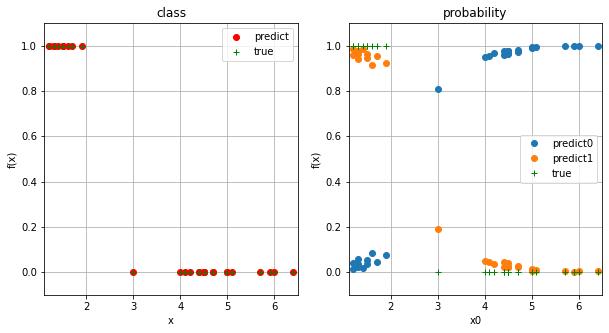

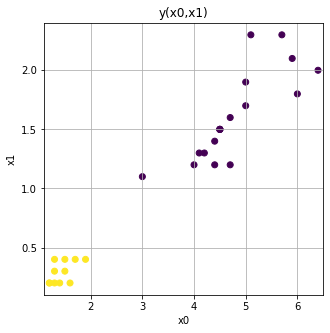

In [28]:
n = 2 # номер признака для визуализации. 
plt.figure(figsize = (10,5))

ymin = y_test_tr.min()-0.1
ymax = y_test_tr.max()+0.1
xmin = X_test_tr[:,n].min()-0.1
xmax = X_test_tr[:,n].max()+0.1

plt.subplot(1,2,1)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.plot(X_test_tr[:,n], y_pred,'or', label = 'predict')
plt.plot(X_test_tr[:,n], y_test_tr, '+g', label = 'true')
plt.grid()
plt.legend()
plt.title('class')

plt.subplot(1,2,2)

plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.title('probability')

for m in range(y_pred_proba.shape[1]):
  if m>1:
    mk = m
  else : mk = 1
  plt.plot(X_test_tr[:,n], y_pred_proba[:,m]*mk,'o', label = 'predict'+ str(m) )

plt.plot(X_test_tr[:,n], y_test_tr, '+g', label = 'true')
plt.grid()
plt.legend()
plt.xlabel('x0')
plt.ylabel('f(x)')

plt.show()


plt.figure(figsize = (5,5))
n2 = 3
xmin0 = X_test_tr[:,n2].min()-0.1
xmax0 = X_test_tr[:,n2].max()+0.1

plt.xlabel('x0')
plt.ylabel('x1')
plt.ylim(xmin0,xmax0)
plt.xlim(xmin,xmax)
plt.scatter(X_test_tr[:,n],X_test_tr[:,n2], c = y_test_tr)
plt.title('y(x0,x1)')

plt.grid()
plt.show()

Вывод: лучше всего разделение проходит по признаку х0.

In [29]:
#Отчет по классификации
print(classification_report(y_test_tr, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



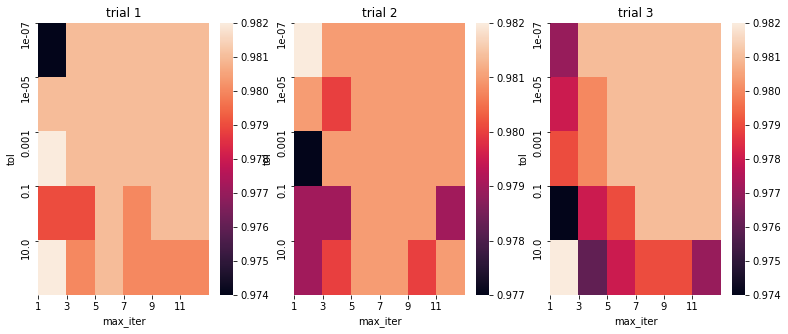

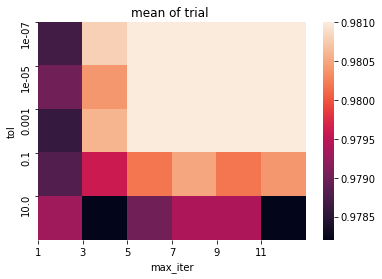

In [50]:
rez = []
K = 10
for tol in np.logspace(-7,1,5):
  for max_iter in range(1,12,2):
    acc = []
    for k in range(K):
      logistic_regressor = LogisticRegression( tol = tol, max_iter=max_iter, solver = 'saga')
      # обучим ее
      logistic_regressor.fit(X_train_tr, y_train_tr)
      y_pred = logistic_regressor.predict(X_test_tr) 
      acc += [accuracy_score(y_test_tr,y_pred)]
    rez += [[tol,max_iter]+ acc]

rez = np.array(rez)

# Визуализация результата в форме тепловой диаграммы для отдельных реализаций
plt.figure(figsize = (13,5))
for i in [1,2,3]:
  plt.subplot(1,3,i)
  acc_all = rez[:,-i].reshape(5,6)
  sns.heatmap(acc_all)
  plt.title('trial '+str(i))
  plt.xlabel('max_iter')
  plt.xticks(list(range(6)),[str(x) for x in range(1,12,2)])
  plt.ylabel('tol')
  plt.yticks(list(range(5)),[str(x) for x in np.logspace(-7,1,5)])
plt.show()

# Визуализация результата в форме тепловой диаграммы для среднего по всем реализациям (можно еще и разбросс смотреть)

acc_mean = rez[:,-K:].mean(axis=1).reshape(5,6)
sns.heatmap(acc_mean)
plt.title('mean of trial ')
plt.xlabel('max_iter')
plt.xticks(list(range(6)),[str(x) for x in range(1,12,2)])
plt.ylabel('tol')
plt.yticks(list(range(5)),[str(x) for x in np.logspace(-7,1,5)])
plt.show()


Вывод: необходимо больле 9 итераций.

### **Задание 4.**

Самостоятельно оценить данные по варианту:

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:

V1 = datasets.load_wine()
V2 = datasets.load_digits()
V3 = datasets.load_breast_cancer()
V4 = datasets.make_classification(n_samples = 1000, n_features=10, n_redundant=2, n_informative=2,random_state=10, n_clusters_per_class=2)
V5 = datasets.make_blobs(n_samples=1000, centers=2, n_features=5, random_state=10)

 4.1.Загрузить данные  по варианту 

 4.2.Построить линейный классификатор в формате sklearn (LogisticRegression https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) и в коде из Задания 1.
 
 4.3. Выбрать метрику (учитываем балансировку данных и смысл задачи) и оценить качество модели на отложенной выборке
 
 4.4. сделать выводы о качестве для модели из задания 1 и sklearn на основе выбранной метрики

 4.5. Привести все признаки к одному диапазону (0,1) (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) или провести стандартизацию признаков (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) , построить модель в sklearn и оценить метрики на отложеной выборке
 
 4.6. Построить классификатор с изменением основных гиперпараметров (по sklearn) : эксперимент по каждому направлению отдельно : penalty  {'l2', 'l1'}, tol = [0.0001, 0.001, 0.01, 0.1], max_iter=[1,2,5,10, 20,50,100,500]. Зафиксировать в каждом эксперименте(при изменении одного из параметров) accuracy, f1,точность, полнота, РR_auc,  ROC_auc в таблице результатов.
 
 4.7 Повторить кадый эксперимент 5-10 раз для всех вариантов значений и построить зависимость метрики от каждого из гиперпараметров отдельно (или парами в виде тепловой диаграммы)

 4.8 Сделать выводы о качестве модели

In [33]:
V5 = datasets.make_blobs(n_samples=1000, centers=2, n_features=5, random_state=10)

In [34]:
X5 = V5[0][:,1:3]
y5 = V5[1]
X5.shape
# Разделение данных на обучающую и тестовую выборки
X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(X5, y5, test_size=0.3, random_state=42)

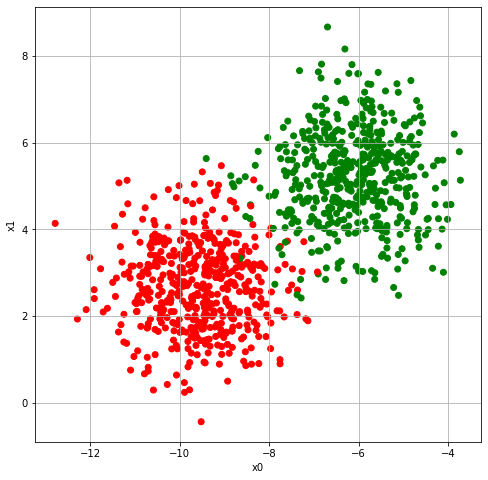

In [35]:
# и изобразим их на графике
colors = ListedColormap(['red', 'blue','green'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in X5], [x[1] for x in X5], c=y5, cmap=colors)
plt.grid()
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [36]:
# создание модели
classification = LogisticRegression(penalty='l2', tol = 0.001, max_iter=10, multi_class='auto', solver='saga',random_state=0).fit(X_train_tr, y_train_tr)
# обучение ее
classification = classification.fit(X_train_tr, y_train_tr) 
# вероятностная оценка класса
y_pred_proba = classification.predict_proba(X_test_tr)
# жесткий ответ (метка класса)
y_pred = classification.predict(X_test_tr)

In [37]:
y_pred_proba.shape

(300, 2)

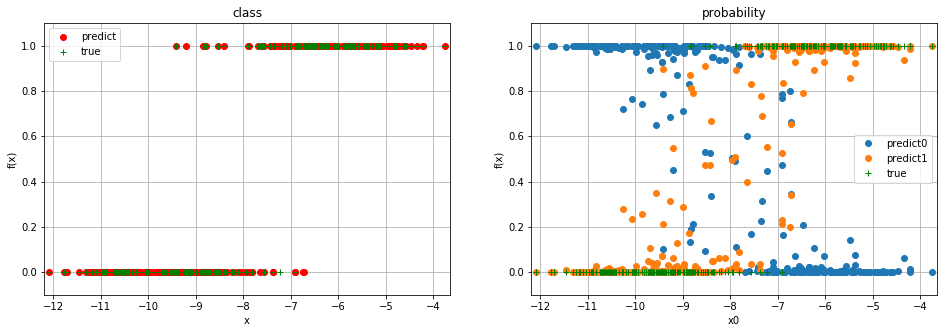

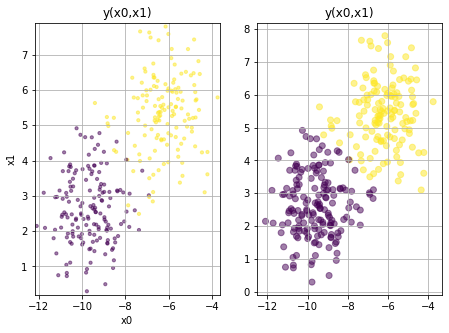

accuracy:  0.9633333333333334


In [38]:
n = 0 # номер признака для визуализации.
plt.figure(figsize = (16,5))

ymin = y_test_tr.min()-0.1
ymax = y_test_tr.max()+0.1
xmin = X_test_tr[:,n].min()-0.1
xmax = X_test_tr[:,n].max()+0.1

plt.subplot(1,2,1)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.plot(X_test_tr[:,n], y_pred,'or', label = 'predict')
plt.plot(X_test_tr[:,n], y_test_tr, '+g', label = 'true')
plt.grid()
plt.legend()
plt.title('class')

plt.subplot(1,2,2)

plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.title('probability')

for m in range(y_pred_proba.shape[1]):
  if m>1:
    mk = m
  else : mk = 1
  plt.plot(X_test_tr[:,n], y_pred_proba[:,m]*mk,'o', label = 'predict'+ str(m) )

plt.plot(X_test_tr[:,n], y_test_tr, '+g', label = 'true')
plt.grid()
plt.legend()
plt.xlabel('x0')
plt.ylabel('f(x)')



plt.show()


plt.figure(figsize = (7.3,5))
n2 = 1
xmin0 = X_test_tr[:,n2].min()-0.1
xmax0 = X_test_tr[:,n2].max()+0.1

plt.subplot(1,2,1)
plt.xlabel('x0')
plt.ylabel('x1')
plt.ylim(xmin0,xmax0)
plt.xlim(xmin,xmax)
# plt.figure(figsize=(6,7))
plt.scatter(X_test_tr[:,n],X_test_tr[:,n2], c = y_test_tr, alpha = 0.5, s = 10)
plt.grid()
plt.title('y(x0,x1)')
plt.subplot(1,2,2)
# plt.figure(figsize=(6,7))
plt.scatter(X_test_tr[:,n],X_test_tr[:,n2], c = y_pred+2, alpha = 0.5)
plt.title('y(x0,x1)')


plt.grid()

plt.show()


print('accuracy: ',accuracy_score(y_test_tr,y_pred))

In [39]:
print(classification_report(y_test_tr, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       159
           1       0.98      0.94      0.96       141

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



In [40]:
#Приведем все признаки к одному диапозону (0,1)
MinMaxScaler()
scaler = MinMaxScaler()
print(scaler.fit(X_train_tr))
MinMaxScaler()
print(scaler.data_max_)

# X_scaled = X_test_tr* (max - min) + min
X_scale = ()

MinMaxScaler(copy=True, feature_range=(0, 1))
[-3.72587956  8.66545923]


In [41]:
X_scale_train = scaler.transform(X_train_tr)
X_scale_train

array([[0.81444437, 0.60581645],
       [0.24649885, 0.47160143],
       [0.75547806, 0.64174544],
       ...,
       [0.67829844, 0.65780547],
       [0.72563774, 0.54756569],
       [0.80623276, 0.46605704]])

In [42]:
X_scale_test = scaler.transform(X_test_tr)
# X_scale_test

In [43]:
# создание модели тренировочых данных
classification_train = LogisticRegression(penalty='l2', tol = 0.001, max_iter=10, multi_class='auto', solver='saga',random_state=0).fit(X_scale_train, y_train_tr)
# обучение ее
classification_train = classification_train.fit(X_scale_train, y_train_tr) 
# вероятностная оценка класса
y_pred_proba_train = classification_train.predict_proba(X_scale_train)
# жесткий ответ (метка класса)
y_pred_train = classification_train.predict(X_scale_train)

In [44]:
 # вероятностная оценка класса
y_pred_proba_test = classification_train.predict_proba(X_scale_test)
# жесткий ответ (метка класса)
y_pred_test = classification_train.predict(X_scale_test)

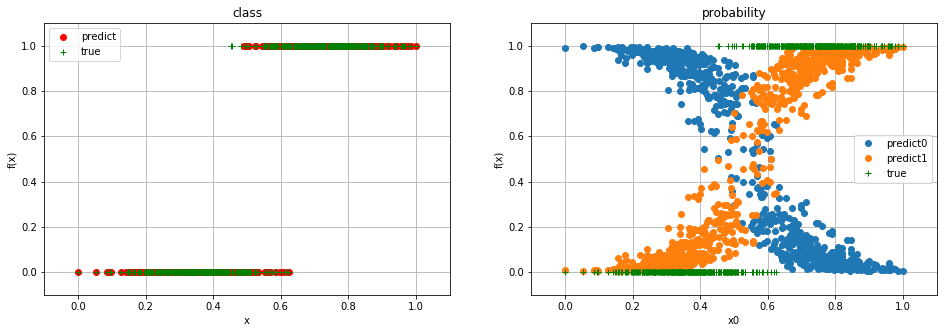

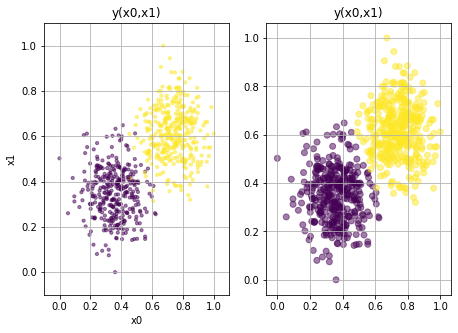

accuracy:  0.9857142857142858


In [45]:
n = 0 # номер признака для визуализации.
plt.figure(figsize = (16,5))

ymin = y_test_tr.min()-0.1
ymax = y_test_tr.max()+0.1
xmin = X_scale_train[:,n].min()-0.1
xmax = X_scale_train[:,n].max()+0.1

plt.subplot(1,2,1)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.plot(X_scale_train[:,n], y_pred_train,'or', label = 'predict')
plt.plot(X_scale_train[:,n], y_train_tr, '+g', label = 'true')
plt.grid()
plt.legend()
plt.title('class')

plt.subplot(1,2,2)

plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.title('probability')

for m in range(y_pred_proba_train.shape[1]):
  if m>1:
    mk = m
  else : mk = 1
  plt.plot(X_scale_train[:,n], y_pred_proba_train[:,m]*mk,'o', label = 'predict'+ str(m) )

plt.plot(X_scale_train[:,n], y_train_tr, '+g', label = 'true')
plt.grid()
plt.legend()
plt.xlabel('x0')
plt.ylabel('f(x)')



plt.show()


plt.figure(figsize = (7.3,5))
n2 = 1
xmin0 = X_scale_train[:,n2].min()-0.1
xmax0 = X_scale_train[:,n2].max()+0.1

plt.subplot(1,2,1)
plt.xlabel('x0')
plt.ylabel('x1')
plt.ylim(xmin0,xmax0)
plt.xlim(xmin,xmax)
# plt.figure(figsize=(6,7))
plt.scatter(X_scale_train[:,n],X_scale_train[:,n2], c = y_train_tr, alpha = 0.5, s = 10)
plt.grid()
plt.title('y(x0,x1)')
plt.subplot(1,2,2)
# plt.figure(figsize=(6,7))
plt.scatter(X_scale_train[:,n],X_scale_train[:,n2], c = y_pred_train+2, alpha = 0.5)
plt.title('y(x0,x1)')


plt.grid()

plt.show()


print('accuracy: ',accuracy_score(y_train_tr,y_pred_train))

In [46]:
print(classification_report(y_train_tr, y_pred_train))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       341
           1       0.99      0.98      0.99       359

    accuracy                           0.99       700
   macro avg       0.99      0.99      0.99       700
weighted avg       0.99      0.99      0.99       700



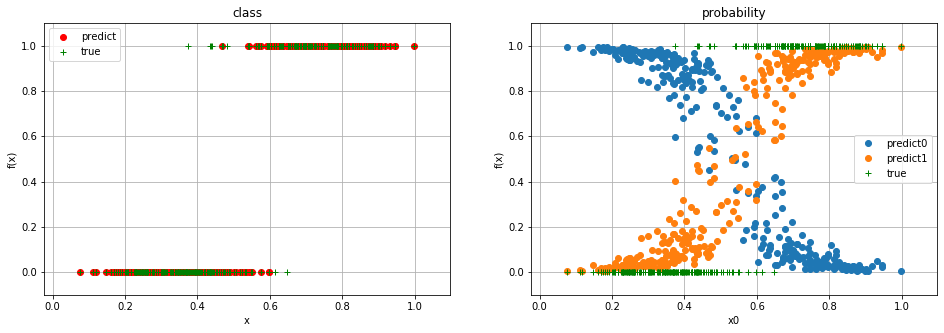

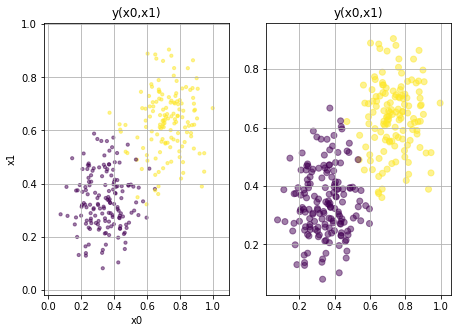

accuracy:  0.9666666666666667


In [47]:
n = 0 # номер признака для визуализации.
plt.figure(figsize = (16,5))

ymin = y_test_tr.min()-0.1
ymax = y_test_tr.max()+0.1
xmin = X_scale_test[:,n].min()-0.1
xmax = X_scale_test[:,n].max()+0.1

plt.subplot(1,2,1)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.plot(X_scale_test[:,n], y_pred_test,'or', label = 'predict')
plt.plot(X_scale_test[:,n], y_test_tr, '+g', label = 'true')
plt.grid()
plt.legend()
plt.title('class')

plt.subplot(1,2,2)

plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.title('probability')

for m in range(y_pred_proba_test.shape[1]):
  if m>1:
    mk = m
  else : mk = 1
  plt.plot(X_scale_test[:,n], y_pred_proba_test[:,m]*mk,'o', label = 'predict'+ str(m) )

plt.plot(X_scale_test[:,n], y_test_tr, '+g', label = 'true')
plt.grid()
plt.legend()
plt.xlabel('x0')
plt.ylabel('f(x)')



plt.show()


plt.figure(figsize = (7.3,5))
n2 = 1
xmin0 = X_scale_test[:,n2].min()-0.1
xmax0 = X_scale_test[:,n2].max()+0.1

plt.subplot(1,2,1)
plt.xlabel('x0')
plt.ylabel('x1')
plt.ylim(xmin0,xmax0)
plt.xlim(xmin,xmax)
# plt.figure(figsize=(6,7))
plt.scatter(X_scale_test[:,n],X_scale_test[:,n2], c = y_test_tr, alpha = 0.5, s = 10)
plt.grid()
plt.title('y(x0,x1)')
plt.subplot(1,2,2)
# plt.figure(figsize=(6,7))
plt.scatter(X_scale_test[:,n],X_scale_test[:,n2], c = y_pred_test+2, alpha = 0.5)
plt.title('y(x0,x1)')

plt.grid()

plt.show()


print('accuracy: ',accuracy_score(y_test_tr,y_pred_test))

In [48]:
print(classification_report(y_test_tr, y_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       159
           1       0.99      0.94      0.96       141

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



Вывод: тестовая выборка имеет хуже accuracy

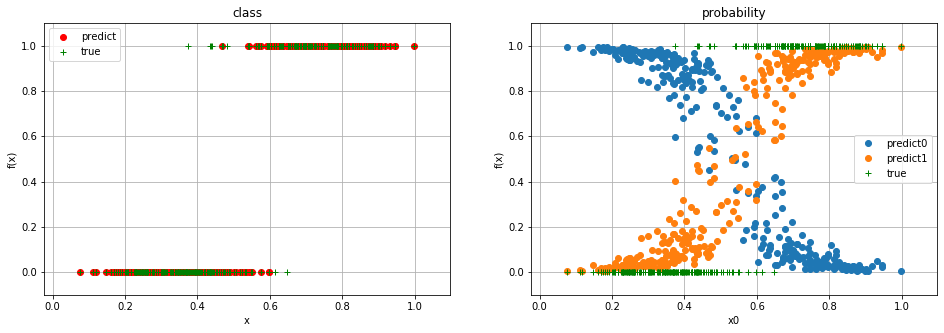

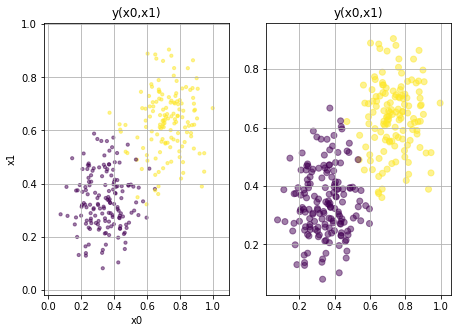

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       159
           1       0.99      0.94      0.96       141

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



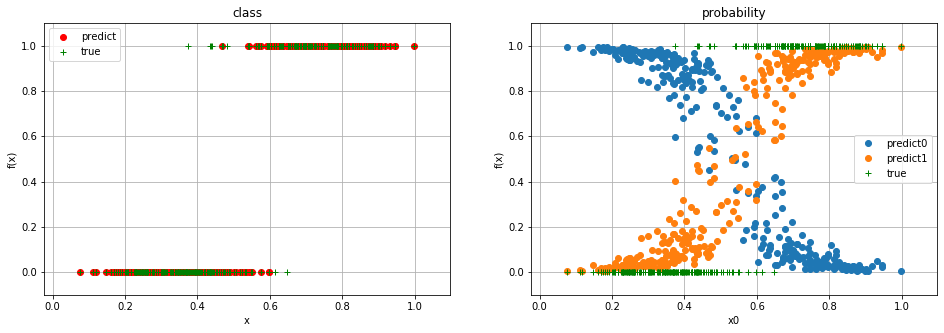

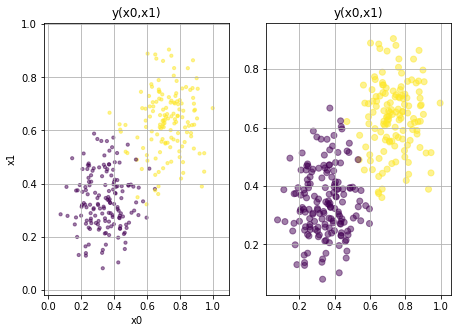

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       159
           1       0.99      0.94      0.96       141

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



In [49]:
pen = ['l1','l2']
tab1 = list([])
for i in range(2):
  # создание модели тренировочых данных
  y_pred_train = LogisticRegression(penalty=pen[i], tol = 0.001, max_iter=10, multi_class='auto', solver='saga',random_state=0).fit(X_scale_train, y_train_tr)
  # обучение ее
  y_pred_train = y_pred_train.fit(X_scale_train, y_train_tr) 
  # вероятностная оценка класса
  y_pred_proba_train = y_pred_train.predict_proba(X_scale_train)
  # жесткий ответ (метка класса)
  y_pred_train = y_pred_train.predict(X_scale_train)
  n = 0 # номер признака для визуализации.
  plt.figure(figsize = (16,5))

  ymin = y_test_tr.min()-0.1
  ymax = y_test_tr.max()+0.1
  xmin = X_scale_test[:,n].min()-0.1
  xmax = X_scale_test[:,n].max()+0.1

  plt.subplot(1,2,1)
  plt.xlabel('x')
  plt.ylabel('f(x)')
  plt.ylim(ymin,ymax)
  plt.xlim(xmin,xmax)
  plt.plot(X_scale_test[:,n], y_pred_test,'or', label = 'predict')
  plt.plot(X_scale_test[:,n], y_test_tr, '+g', label = 'true')
  plt.grid()
  plt.legend()
  plt.title('class')

  plt.subplot(1,2,2)

  plt.ylim(ymin,ymax)
  plt.xlim(xmin,xmax)
  plt.title('probability')

  for m in range(y_pred_proba_test.shape[1]):
    if m>1:
      mk = m
    else : mk = 1
    plt.plot(X_scale_test[:,n], y_pred_proba_test[:,m]*mk,'o', label = 'predict'+ str(m) )

  plt.plot(X_scale_test[:,n], y_test_tr, '+g', label = 'true')
  plt.grid()
  plt.legend()
  plt.xlabel('x0')
  plt.ylabel('f(x)')



  plt.show()


  plt.figure(figsize = (7.3,5))
  n2 = 1
  xmin0 = X_scale_test[:,n2].min()-0.1
  xmax0 = X_scale_test[:,n2].max()+0.1

  plt.subplot(1,2,1)
  plt.xlabel('x0')
  plt.ylabel('x1')
  plt.ylim(xmin0,xmax0)
  plt.xlim(xmin,xmax)
  # plt.figure(figsize=(6,7))
  plt.scatter(X_scale_test[:,n],X_scale_test[:,n2], c = y_test_tr, alpha = 0.5, s = 10)
  plt.grid()
  plt.title('y(x0,x1)')
  plt.subplot(1,2,2)
  # plt.figure(figsize=(6,7))
  plt.scatter(X_scale_test[:,n],X_scale_test[:,n2], c = y_pred_test+2, alpha = 0.5)
  plt.title('y(x0,x1)')

  plt.grid()

  plt.show()

  print(classification_report(y_test_tr, y_pred_test))
  tab1.append(accuracy_score(y_test_tr,y_pred_test))

In [50]:
tab1_p = pd.DataFrame(tab1, index = pen) 
tab1_p

,0
l1,0.966667
l2,0.966667


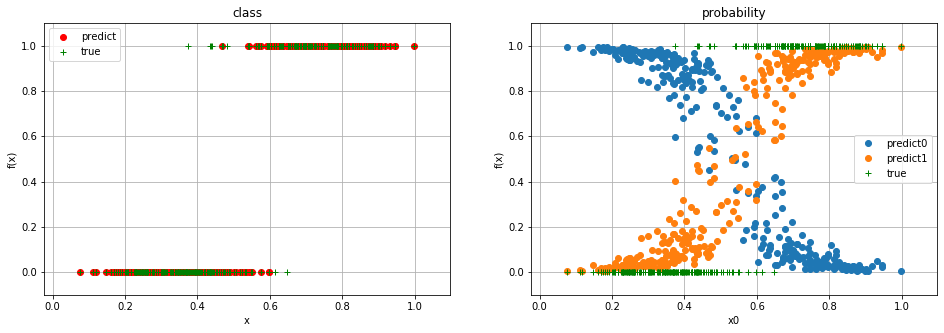

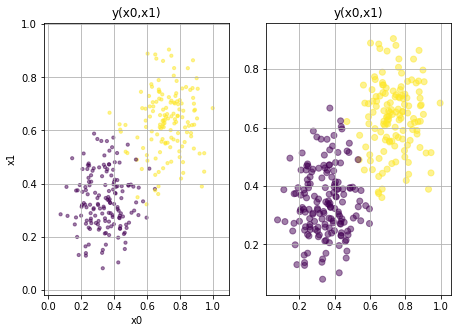

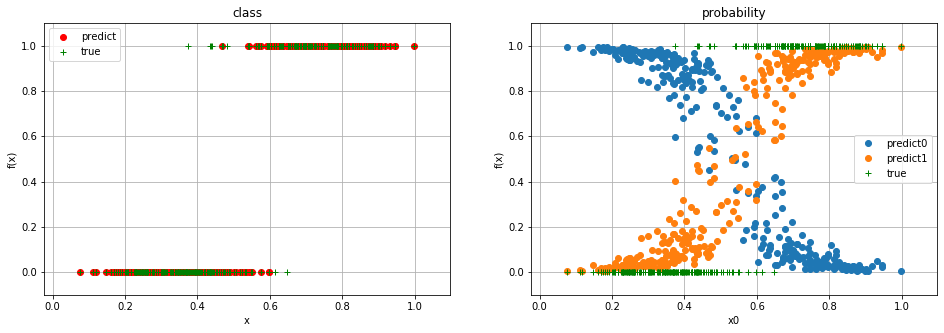

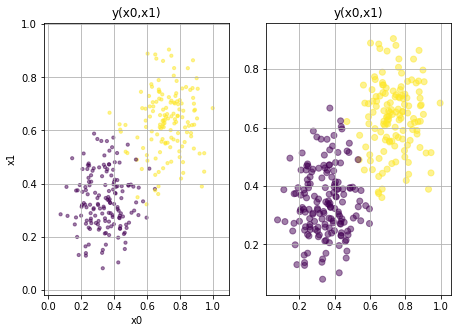

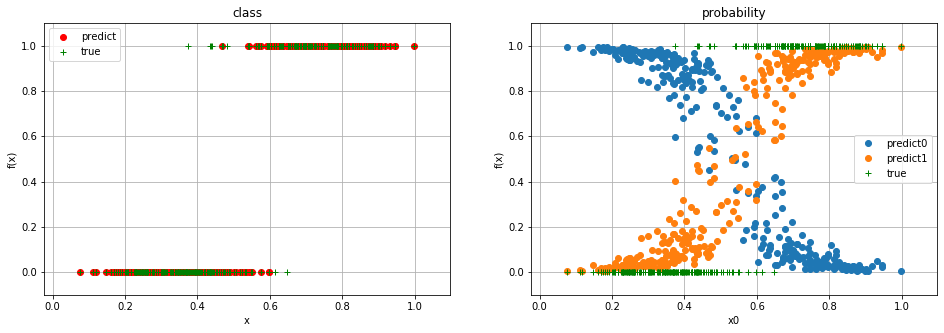

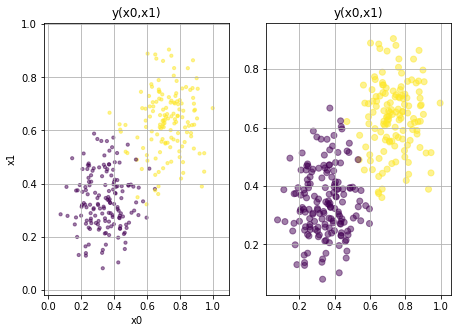

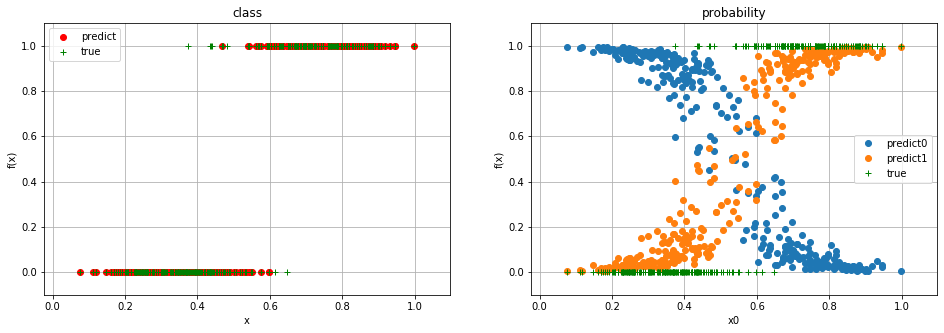

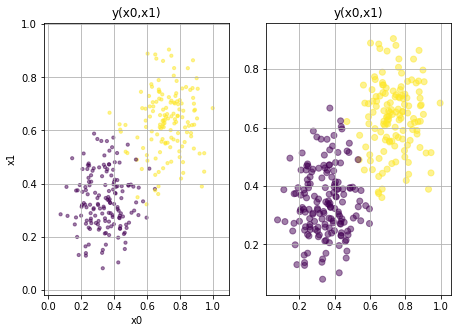

In [51]:
to = [0.0001,0.001,0.01,0.1]
tab2 = list([])
for i in range(4):
  # создание модели тренировочых данных
  y_pred_train = LogisticRegression(penalty='l2', tol = to[i], max_iter=10, multi_class='auto', solver='saga',random_state=0).fit(X_scale_train, y_train_tr)
  # обучение ее
  y_pred_train = y_pred_train.fit(X_scale_train, y_train_tr) 
  # вероятностная оценка класса
  y_pred_proba_train = y_pred_train.predict_proba(X_scale_train)
  # жесткий ответ (метка класса)
  y_pred_train = y_pred_train.predict(X_scale_train)
  n = 0 # номер признака для визуализации.
  plt.figure(figsize = (16,5))

  ymin = y_test_tr.min()-0.1
  ymax = y_test_tr.max()+0.1
  xmin = X_scale_test[:,n].min()-0.1
  xmax = X_scale_test[:,n].max()+0.1

  plt.subplot(1,2,1)
  plt.xlabel('x')
  plt.ylabel('f(x)')
  plt.ylim(ymin,ymax)
  plt.xlim(xmin,xmax)
  plt.plot(X_scale_test[:,n], y_pred_test,'or', label = 'predict')
  plt.plot(X_scale_test[:,n], y_test_tr, '+g', label = 'true')
  plt.grid()
  plt.legend()
  plt.title('class')

  plt.subplot(1,2,2)

  plt.ylim(ymin,ymax)
  plt.xlim(xmin,xmax)
  plt.title('probability')

  for m in range(y_pred_proba_test.shape[1]):
    if m>1:
      mk = m
    else : mk = 1
    plt.plot(X_scale_test[:,n], y_pred_proba_test[:,m]*mk,'o', label = 'predict'+ str(m) )

  plt.plot(X_scale_test[:,n], y_test_tr, '+g', label = 'true')
  plt.grid()
  plt.legend()
  plt.xlabel('x0')
  plt.ylabel('f(x)')



  plt.show()


  plt.figure(figsize = (7.3,5))
  n2 = 1
  xmin0 = X_scale_test[:,n2].min()-0.1
  xmax0 = X_scale_test[:,n2].max()+0.1

  plt.subplot(1,2,1)
  plt.xlabel('x0')
  plt.ylabel('x1')
  plt.ylim(xmin0,xmax0)
  plt.xlim(xmin,xmax)
  plt.scatter(X_scale_test[:,n],X_scale_test[:,n2], c = y_test_tr, alpha = 0.5, s = 10)
  plt.grid()
  plt.title('y(x0,x1)')
  plt.subplot(1,2,2)
  plt.scatter(X_scale_test[:,n],X_scale_test[:,n2], c = y_pred_test+2, alpha = 0.5)
  plt.title('y(x0,x1)')

  plt.grid()

  plt.show()


  tab2.append(accuracy_score(y_test_tr,y_pred_test))

In [52]:
# значение accuracy в зависимости от tol
tab2_t = pd.DataFrame(tab2, index = to)
tab2_t

,0
0.0001,0.966667
0.0010,0.966667
0.0100,0.966667
0.1000,0.966667


Вывод: при любой толерантности значение accuracy одинаковое

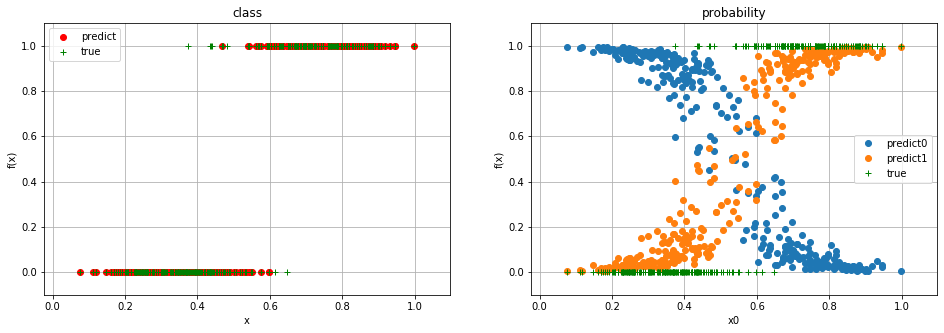

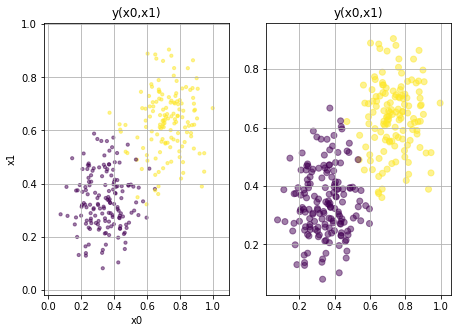

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       159
           1       0.99      0.94      0.96       141

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



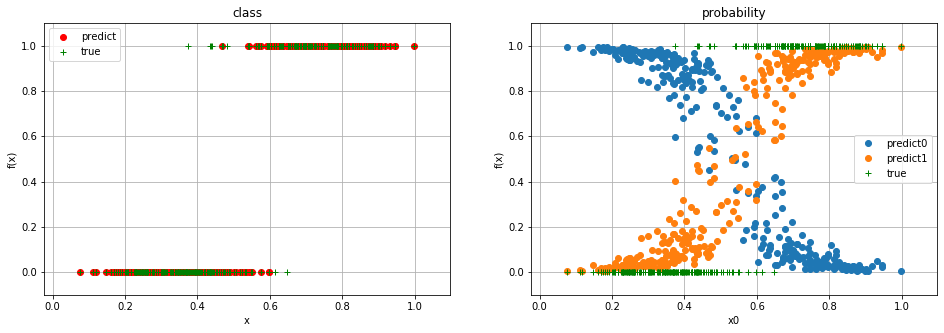

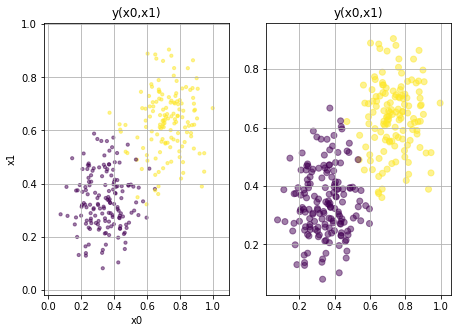

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       159
           1       0.99      0.94      0.96       141

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



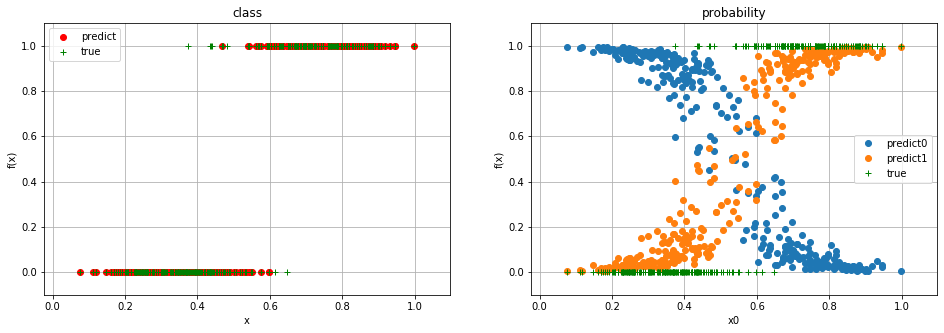

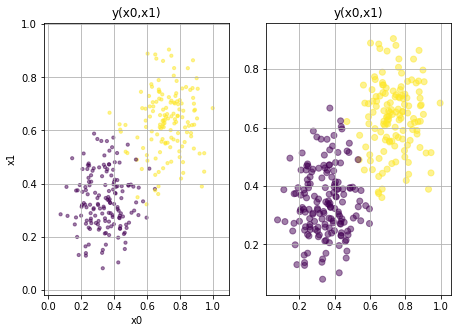

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       159
           1       0.99      0.94      0.96       141

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



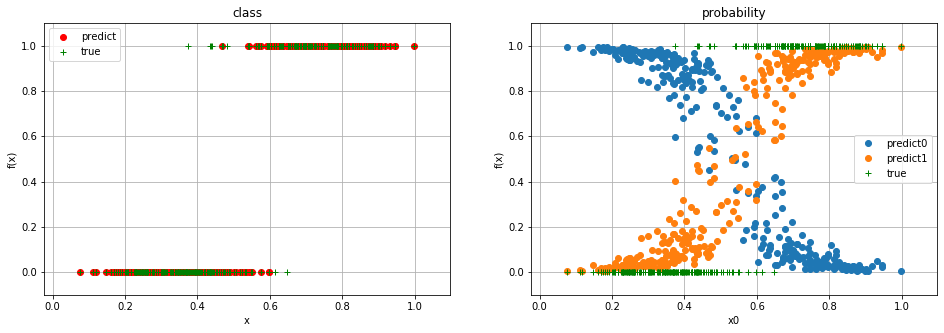

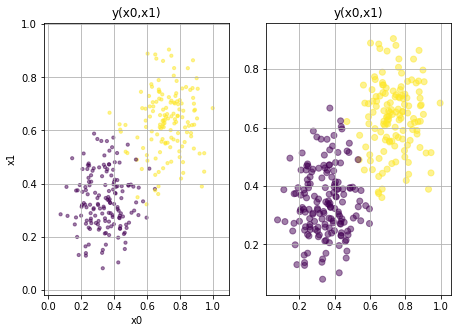

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       159
           1       0.99      0.94      0.96       141

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



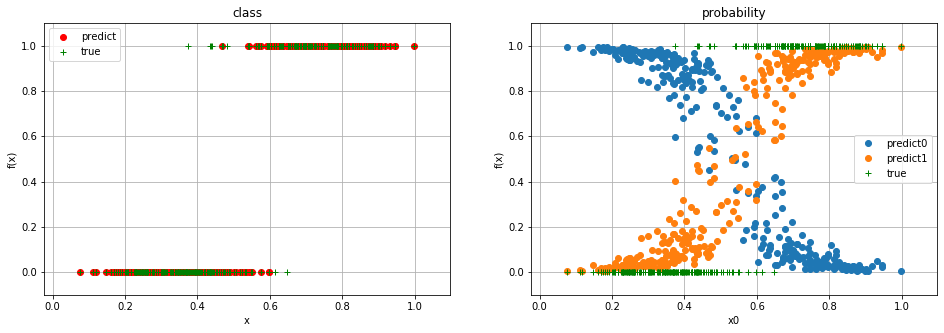

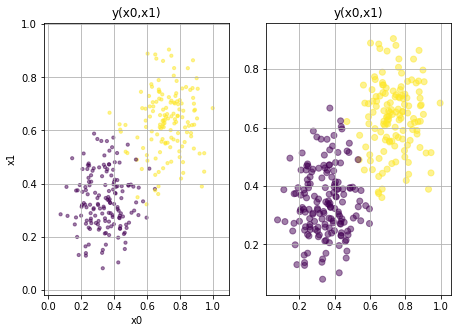

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       159
           1       0.99      0.94      0.96       141

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



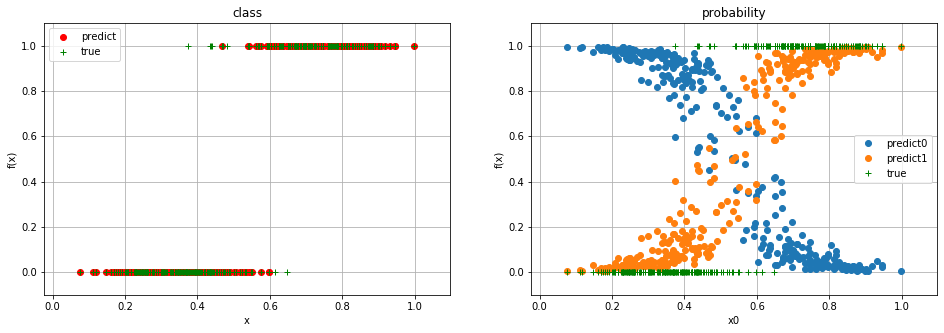

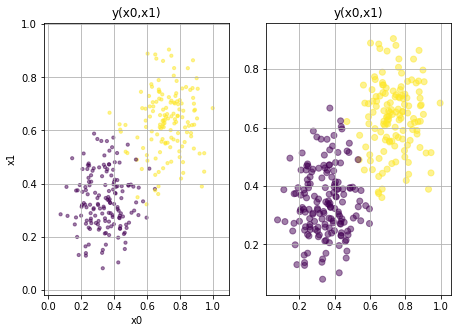

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       159
           1       0.99      0.94      0.96       141

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



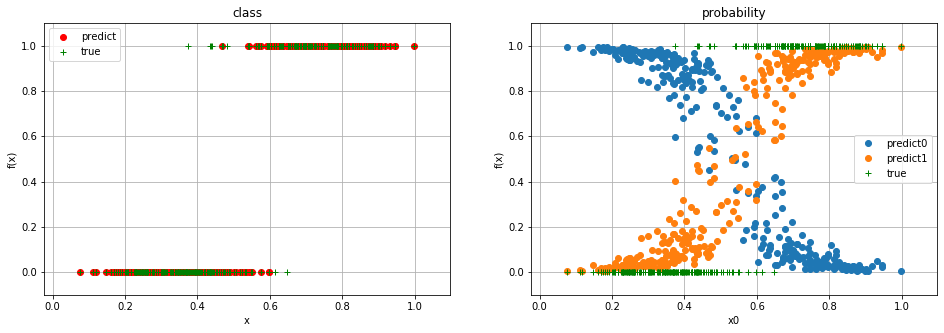

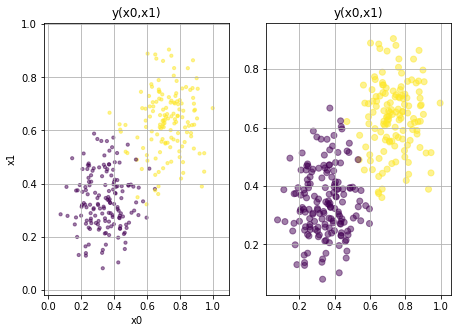

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       159
           1       0.99      0.94      0.96       141

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



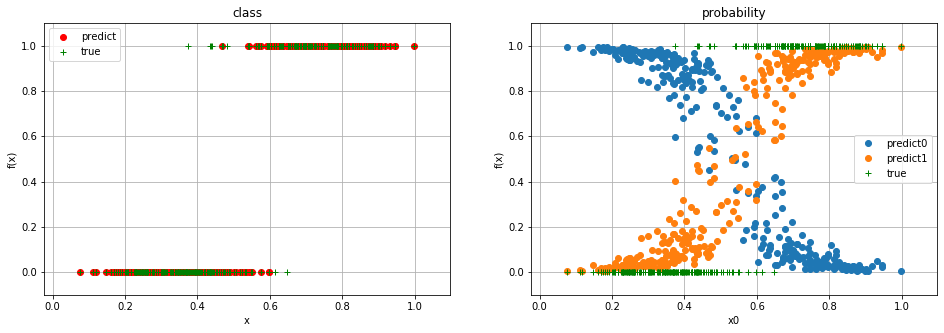

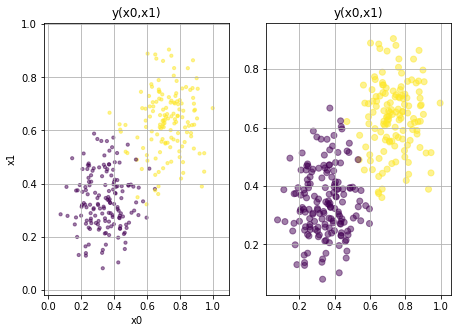

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       159
           1       0.99      0.94      0.96       141

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



In [53]:
max_itr=[1,2,5,10, 20,50,100,500]
tab3 = list([])
for i in range(8):
  # создание модели тренировочых данных
  y_pred_train = LogisticRegression(penalty='l2', tol = 0.001, max_iter=max_itr[i], multi_class='auto', solver='saga',random_state=0).fit(X_scale_train, y_train_tr)
  # обучение ее
  y_pred_train = y_pred_train.fit(X_scale_train, y_train_tr) 
  # вероятностная оценка класса
  y_pred_proba_train = y_pred_train.predict_proba(X_scale_train)
  # жесткий ответ (метка класса)
  y_pred_train = y_pred_train.predict(X_scale_train)
  n = 0 # номер признака для визуализации.
  plt.figure(figsize = (16,5))

  ymin = y_test_tr.min()-0.1
  ymax = y_test_tr.max()+0.1
  xmin = X_scale_test[:,n].min()-0.1
  xmax = X_scale_test[:,n].max()+0.1

  plt.subplot(1,2,1)
  plt.xlabel('x')
  plt.ylabel('f(x)')
  plt.ylim(ymin,ymax)
  plt.xlim(xmin,xmax)
  plt.plot(X_scale_test[:,n], y_pred_test,'or', label = 'predict')
  plt.plot(X_scale_test[:,n], y_test_tr, '+g', label = 'true')
  plt.grid()
  plt.legend()
  plt.title('class')

  plt.subplot(1,2,2)

  plt.ylim(ymin,ymax)
  plt.xlim(xmin,xmax)
  plt.title('probability')

  for m in range(y_pred_proba_test.shape[1]):
    if m>1:
      mk = m
    else : mk = 1
    plt.plot(X_scale_test[:,n], y_pred_proba_test[:,m]*mk,'o', label = 'predict'+ str(m) )

  plt.plot(X_scale_test[:,n], y_test_tr, '+g', label = 'true')
  plt.grid()
  plt.legend()
  plt.xlabel('x0')
  plt.ylabel('f(x)')



  plt.show()


  plt.figure(figsize = (7.3,5))
  n2 = 1
  xmin0 = X_scale_test[:,n2].min()-0.1
  xmax0 = X_scale_test[:,n2].max()+0.1

  plt.subplot(1,2,1)
  plt.xlabel('x0')
  plt.ylabel('x1')
  plt.ylim(xmin0,xmax0)
  plt.xlim(xmin,xmax)
  plt.scatter(X_scale_test[:,n],X_scale_test[:,n2], c = y_test_tr, alpha = 0.5, s = 10)
  plt.grid()
  plt.title('y(x0,x1)')
  plt.subplot(1,2,2)
  plt.scatter(X_scale_test[:,n],X_scale_test[:,n2], c = y_pred_test+2, alpha = 0.5)
  plt.title('y(x0,x1)')

  plt.grid()

  plt.show()

  print(classification_report(y_test_tr, y_pred_test))
  tab3.append(accuracy_score(y_test_tr,y_pred_test))

In [54]:
# значение accuracy в зависимости от максимального числа итераций
tab3_m = pd.DataFrame(tab3, index = max_itr)
tab3_m

,0
1,0.966667
2,0.966667
5,0.966667
10,0.966667
20,0.966667
50,0.966667
100,0.966667
500,0.966667


Вывод: после первой операции можно было остановиться

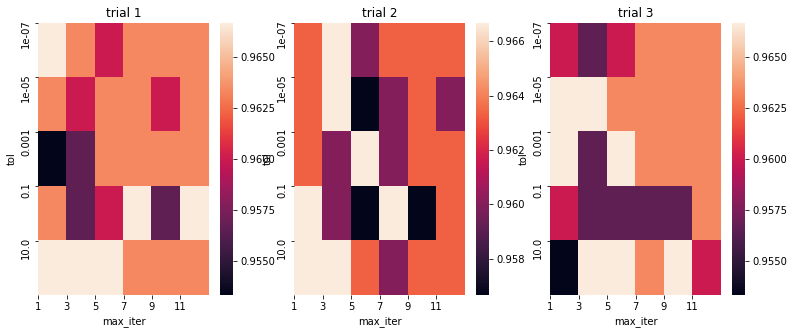

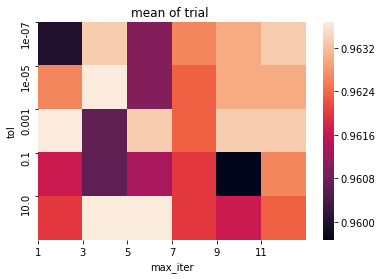

In [61]:
rez = []
K = 10
for tol in np.logspace(-7,1,5):
  for max_iter in range(1,12,2):
    acc = []
    for k in range(K):
      logistic_regressor = LogisticRegression( tol = tol, max_iter=max_iter, solver = 'saga')
      # обучим ее
      logistic_regressor.fit(X_train_tr, y_train_tr)
      y_pred = logistic_regressor.predict(X_test_tr) 
      acc += [accuracy_score(y_test_tr,y_pred)]
    rez += [[tol,max_iter]+ acc]

rez = np.array(rez)

# Визуализация результата в форме тепловой диаграммы для отдельных реализаций
plt.figure(figsize = (13,5))
for i in [1,2,3]:
  plt.subplot(1,3,i)
  acc_all = rez[:,-i].reshape(5,6)
  sns.heatmap(acc_all)
  plt.title('trial '+str(i))
  plt.xlabel('max_iter')
  plt.xticks(list(range(6)),[str(x) for x in range(1,12,2)])
  plt.ylabel('tol')
  plt.yticks(list(range(5)),[str(x) for x in np.logspace(-7,1,5)])
plt.show()

# Визуализация результата в форме тепловой диаграммы для среднего по всем реализациям (можно еще и разбросс смотреть)

acc_mean = rez[:,-K:].mean(axis=1).reshape(5,6)
sns.heatmap(acc_mean)
plt.title('mean of trial ')
plt.xlabel('max_iter')
plt.xticks(list(range(6)),[str(x) for x in range(1,12,2)])
plt.ylabel('tol')
plt.yticks(list(range(5)),[str(x) for x in np.logspace(-7,1,5)])
plt.show()


Из диаграмм видно, что необходимо 5 итераций при максимальной толерантности

Резюме Логистической регрессии:

  - Делает численные оценки вероятности его принадлежности каждому из классов.

  - Является частным случаем обобщённой линейной модели регрессии

  - Оценки вероятностей и рисков могут оказаться неадекватными, если не признаки зависимы
  - Практичная реализация должна предусматривать :
      - стандартизацию данных, 
      - отсев выбросов, 
      - регуляризацию,
      - отбор признаков.